In [1]:
import json, re
import pickle
from collections import Counter
import matplotlib.pyplot as plt

root = "../Coco data/val2014" # directory of images
cocofile = "../Coco data/annotations/captions_val2014.json" #captions are here

In [2]:
class Vocab(object):
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = int(self.idx)
            self.idx2word[self.idx] = word
            self.idx += 1

    def get_word(self, idx):
        #assert idx < len(self.idx2word)
        return self.idx2word[idx]

    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

def make_vocab(filename, threshold=5):
    #coco = COCO(datafile)
    ##ids = coco.anns.keys()
    #for i, key in enumerate(coco.anns.keys()):
        #caption = str(coco.anns[key]['caption'])
    with open(filename, 'r') as f:
        coco = json.load(f)
    anns = coco['annotations']
    words = []
    counter = Counter()
    for i in range(len(anns)):
        caption = str(anns[i]['caption'])
        #tokens = nltk.tokenize.word_tokenize(caption.lower())
        tokens = re.findall(r"[\w']+", str(caption).lower())
        #words.extend(tokens)
        counter.update(tokens)

    #words = [word for word, cnt in counter.items() if cnt >= 1000]
    vocab = Vocab()
    vocab.add_word('<null>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')
    #for i, word in enumerate(words):
    for word, count in counter.items():
        if count >= threshold:
            vocab.add_word(word)

    save(vocab, "data/vocab_file2.pkl")
    return vocab

def save(vocab, filename):
    with open(filename, 'wb') as f:
        pickle.dump(vocab, f)
    print("Saved vocab to " + filename)

In [3]:
vocab = make_vocab("../Coco data/annotations/captions_val2014.json",50)
print(len(vocab))
print(vocab('<start>'))
print(vocab('<end>'))
print(vocab('<null>'))
print(vocab('<unk>'))

Saved vocab to data/vocab_file2.pkl
1922
1
2
0
3


In [4]:
from PIL import Image
import torch
import torchvision.transforms as transforms
from torch.autograd import Variable

transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize(mean = [ 0.485, 0.456, 0.406 ],
                                                     std = [ 0.229, 0.224, 0.225 ]),
                                ])

def image_loader(img_name, transform=None):
    """load image, returns tensor"""
    image = Image.open(img_name).convert('RGB')
    image = transform(image).float()
    image = torch.Tensor(image)
    image = Variable(image, requires_grad=False)
    image = image.unsqueeze(0)
    return image

In [5]:
with open(cocofile, 'r') as f:
    coco = json.load(f)
anns = coco['annotations']
image_dic = {}
for ele in coco['images']:
    image_dic.update({ele['id']: ele['file_name']})

print(anns[0])
print(image_dic[anns[0]['image_id']]) #gives image filename associated with caption
print(len(anns)) #number of captions

{'image_id': 203564, 'id': 37, 'caption': 'A bicycle replica with a clock as the front wheel.'}
COCO_val2014_000000203564.jpg
202654


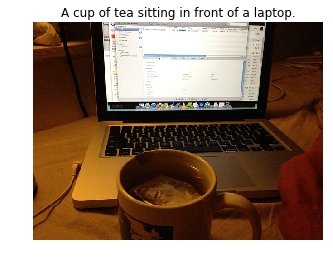

torch.Size([1, 12])
torch.Size([1, 3, 224, 224])


In [6]:
import numpy.random as random
import os

def random_image_cap(show=False):
    idx = random.randint(0, len(anns)+1)
    caption = anns[idx]['caption']
    image_id = anns[idx]['image_id']
    filename = os.path.join(root, image_dic[image_id])
    if show:
        image = Image.open(filename)
        plt.imshow(image)
        plt.title(caption)
        plt.axis('off')
        plt.show()
    
    # preprocessing image and caption
    image = image_loader(filename, transform) #returns torch tensor
    tokens = re.findall(r"[\w']+", str(caption).lower())
    caption = []
    caption.append(vocab('<start>'))
    caption.extend([vocab(token) for token in tokens])
    caption.append(vocab('<end>'))
    caption = torch.LongTensor(caption)
    #caption = Variable(caption, requires_grad=False)
    caption = caption.unsqueeze(0)
    #image = vgg(image)
    return image, caption

for i in range(1):
    i,c = random_image_cap(True)
print(c.size())
print(i.size())

In [7]:
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
vgg = models.vgg19(pretrained=True) # to extract features out of image

In [8]:
def training_batch(batch_size):
    images = []
    caps = []
    max_len = 0
    vgg.eval()
    for i in range(batch_size):
        image, caption = random_image_cap()
        max_len = max(max_len, caption.size(1))
        caps.append(caption)
        images.append(image)
    images = torch.cat(images, dim=0) # image is already a variable
    images = vgg(images)
    #print("here")
    padded_caps = []
    for cap in caps:
        cap = F.pad(cap, (0, max_len - cap.size(1))) #F.pad returns variable
        padded_caps.append(cap)
    padded_caps = torch.cat(padded_caps, dim=0)
                           
    cap_in = padded_caps[:, :-1]
    cap_out = padded_caps[:, 1:]
    return images, cap_in, cap_out

# it'll be better for us to extract these features and keep to save time while actual training

In [9]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [10]:
t0 = time.time()
#i,c_in,c_out = training_batch(64)
print(time_since(t0))
#print(i.size(), c_in.size(), c_out.size())

0m 0s


In [11]:
class CaptionGen(nn.Module):
    def __init__(self, vocab_size, image_dim, embed_dim, hidden_dim):
        super(self.__class__, self).__init__()
        
        self.vocab_size = vocab_size # number of words for this case
        self.hidden_dim = hidden_dim
        self.embed_dim = embed_dim # we could keep this same as hidden dim to reduce one variable
        self.image_dim = image_dim
        
        self.word_embed = nn.Embedding(vocab_size, embed_dim)
        self.image_embed = nn.Linear(image_dim, embed_dim)
        self.rnn = nn.LSTM(embed_dim, hidden_dim, num_layers=1, batch_first=True)
        self.decode = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, image, caps_in, hidden):
        inp = self.image_embed(image)
        inp = inp.unsqueeze(dim=1)
        _, hidden = self.rnn(inp, hidden)
        
        inp2 = self.word_embed(caps_in)
        out, hidden = self.rnn(inp2, hidden)
        out = self.decode(out)
        return out
        
    def init_hidden(self, batch_size):
        return (Variable(torch.zeros(1, batch_size, self.hidden_dim)),
                Variable(torch.zeros(1, batch_size, self.hidden_dim)))
    
    def run(self, image, max_length=30, temp=0.4):
        # run takes full image (without extracted features) as input
        hidden = self.init_hidden(1)
        vgg.eval()
        image = vgg(image)
        inp = self.image_embed(image)
        inp = inp.unsqueeze(dim=1)
        pred = '<start>'
        _, hidden = self.rnn(inp, hidden)
        
        inp = word2idx(pred)
        for i in range(max_length):
            inp = self.word_embed(inp)
            out, hidden = self.rnn(inp, hidden)
            out = self.decode(out)
            out_dist = F.softmax(out.view(-1)/temp, dim=0).data
            idx = torch.multinomial(out_dist, 1)[0]
            pred_token = vocab.get_word(idx)
            pred += " " + pred_token
            inp = word2idx(pred_token)
            if idx == 2:
                # <end>
                return pred
        return pred

def word2idx(word):
    idx = [vocab(word)]
    return Variable(torch.LongTensor(idx).view(1,-1))

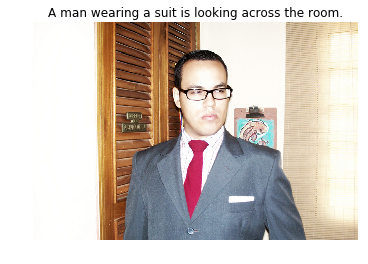

'<start> making motor overlooking on teddy tiny straight falling chef glass before pineapple clear each married stops delivery cupcake dirt paws platform see t players located lies devices vehicle modern bending'

In [12]:
vocab_size, image_dim, embed_dim, hidden_dim = (len(vocab), 1000, 128, 128)
args = (len(vocab), 1000, 128, 128)
capgen = CaptionGen(*args)
#print(len(vocab))
img,c = random_image_cap(True)
capgen.run(img)

In [28]:
def train(batch_size):
    hidden = model.init_hidden(batch_size)
    model.zero_grad()
    loss = 0
    images, caps_in, caps_out = training_batch(batch_size)
    print("fetched.")
    output = model(images, caps_in, hidden)
    caps_out = caps_out.contiguous().view(-1)
    loss = criterion(output.view(-1, vocab_size), caps_out)
    
    loss.backward()
    optimizer.step()
    
    return loss.data[0]

fetched.
 14s (1 10%) 7.5749]


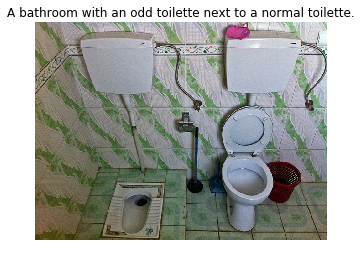

<start> a <end>
fetched.
 16s (2 20%) 6.9264]


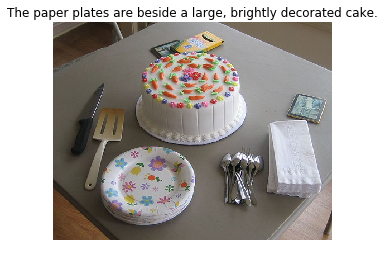

<start> a picture <end>
fetched.
 24s (3 30%) 6.1030]


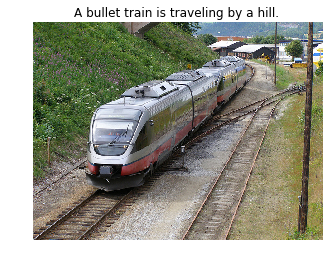

<start> a <end>
fetched.
 46s (4 40%) 5.4075]


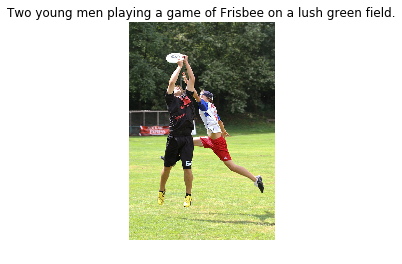

<start> a street of a <end>
fetched.
 52s (5 50%) 5.0325]


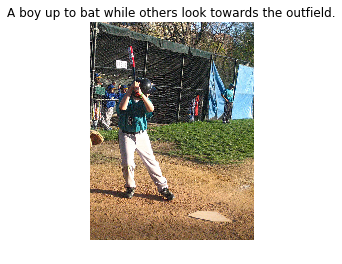

<start> a woman ocean and a tree <end>
fetched.
 38s (6 60%) 4.9866]


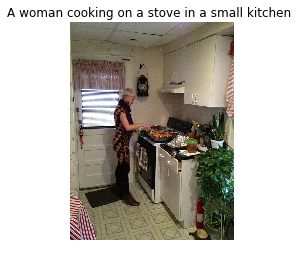

<start> a horse in the <end>
fetched.
 47s (7 70%) 5.0766]


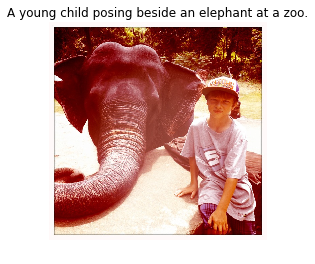

<start> a <unk> <end>
fetched.
 11s (8 80%) 4.7375]


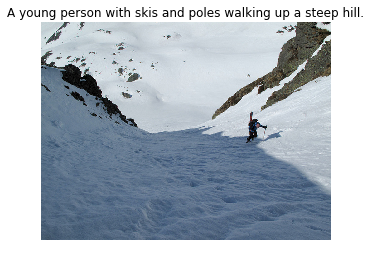

<start> a couple of a man in a man on a picture <end>
fetched.
 23s (9 90%) 4.8945]


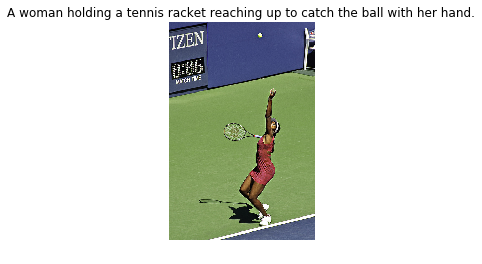

<start> a man and a <unk> <end>
fetched.
 58s (10 100%) 4.8394]


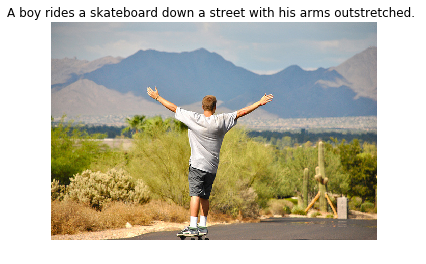

<start> a man <unk> for a <unk> <end>


In [29]:
epochs = 10
print_fq = 1
plot_fq = 10
lr_fq = 100

embed_dim = 128
hidden_dim = 128
batch_size = 32
model = CaptionGen(*args)
lr = 5e-2
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

weights = torch.cat([torch.zeros(1), torch.ones(vocab_size-1)])
criterion = nn.CrossEntropyLoss(weight=weights)

start = time.time()
losses = []
loss_avg = 0

for epoch in range(1, epochs+1):
    loss1 = train(batch_size)
    loss_avg += loss1
    if epoch % print_fq == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / epochs * 100, loss1))
        #print(run('\n', 150, 0.5), '\n')
        img, _ = random_image_cap(True)
        print(model.run(img))
        

    if epoch % plot_fq == 0:
        losses.append(loss_avg / plot_fq)
        loss_avg = 0
    
#print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / epochs * 100, loss1))

fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
 43s (10 2%) 4.2762]


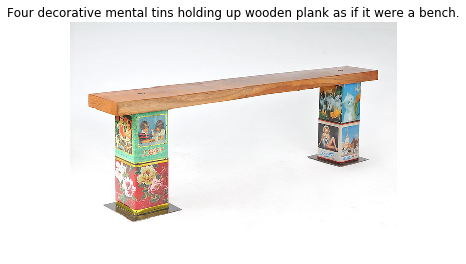

<start> a man in the ball <end>
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
 41s (20 4%) 4.5496]


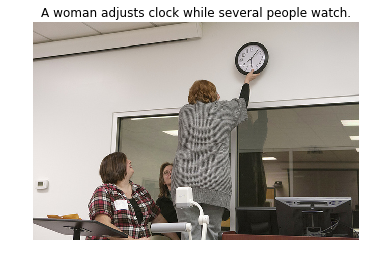

<start> a large computer sits <end>
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
 9s (30 6%) 4.5370]


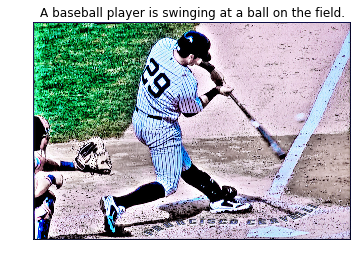

<start> a man sitting on a table <end>
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
 16s (40 8%) 4.2846]


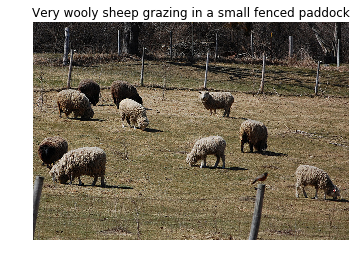

<start> a man in the air <end>
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
 39s (50 10%) 4.4888]


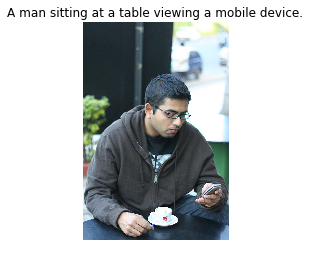

<start> a woman in a person <end>
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
 17s (60 12%) 4.2673]


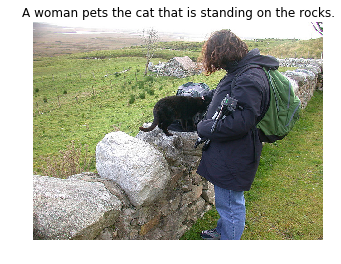

<start> a man holding a <unk> <unk> <end>
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
 37s (70 14%) 4.4316]


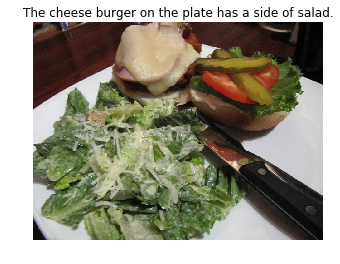

<start> a person on a man is on a person with a <unk> <unk> <unk> <end>
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
 59s (80 16%) 4.1443]


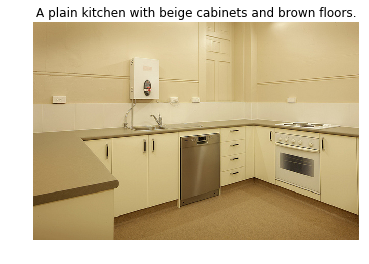

<start> a man is standing on a large group of people on a woman with a <unk> <unk> <end>
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
 44s (90 18%) 4.5375]


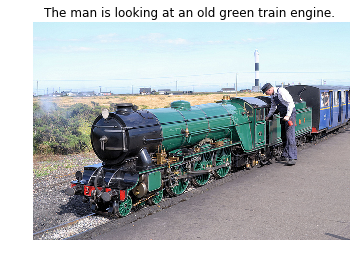

<start> a large sign in the sky <end>
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
 47s (100 20%) 4.5320]


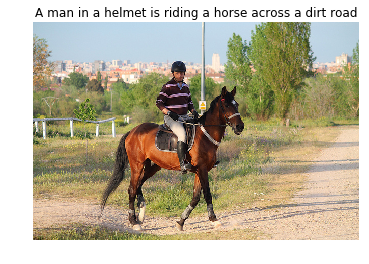

<start> a man is holding a man with a red <end>
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
 45s (110 22%) 4.4123]


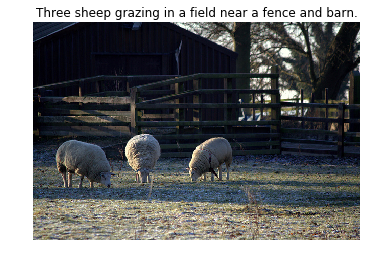

<start> a <unk> <unk> <unk> on a white tall <end>
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
 32s (120 24%) 4.3705]


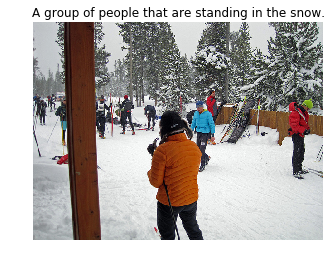

<start> a young woman is sitting on a man in the water <end>
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
 10s (130 26%) 4.2055]


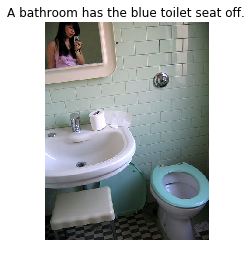

<start> a man is sitting on a man riding a table <end>
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
 13s (140 28%) 4.2785]


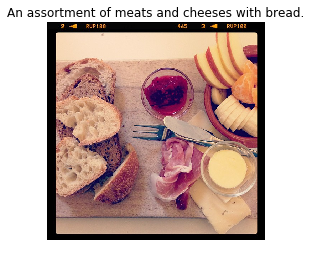

<start> a man in the air on a yellow <end>
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
 51s (150 30%) 4.5123]


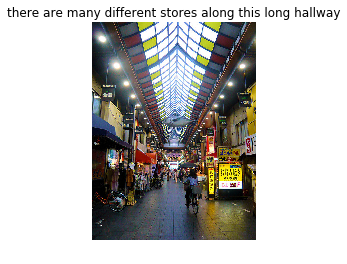

<start> a man is walking with a person on a <unk> <end>
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
 34s (160 32%) 4.1965]


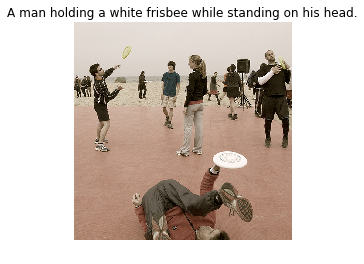

<start> a woman on a <unk> <end>
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
 16s (170 34%) 4.2581]


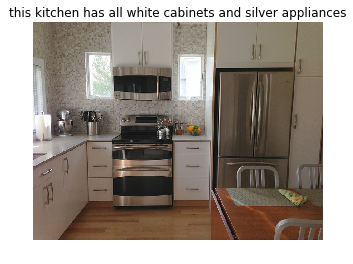

<start> a man is standing on a <unk> <end>
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
 33s (180 36%) 4.1429]


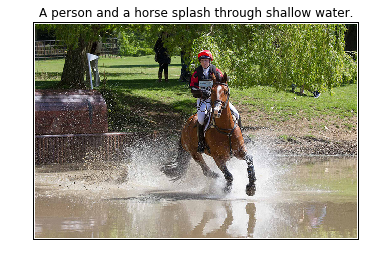

<start> a man is sitting on a <unk> <unk> <end>
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
 59s (190 38%) 4.1187]


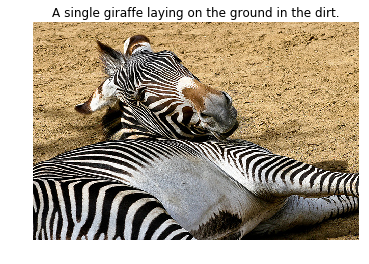

<start> a <unk> <unk> <end>
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
 54s (200 40%) 4.4865]


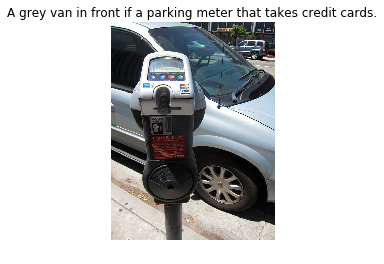

<start> a white and a man and a <unk> <unk> <unk> <end>
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
 20s (210 42%) 4.4864]


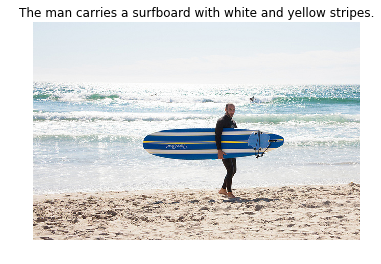

<start> a man in a computer and a <unk> <end>
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
 22s (220 44%) 4.1314]


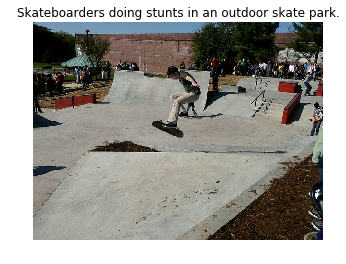

<start> a man is holding a <unk> and a <unk> <end>
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
 47s (230 46%) 4.2200]


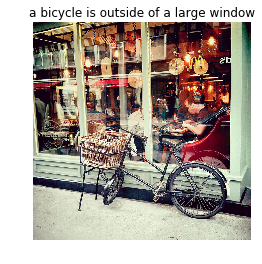

<start> a <unk> of people on a red <end>
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
 0s (240 48%) 4.1715]


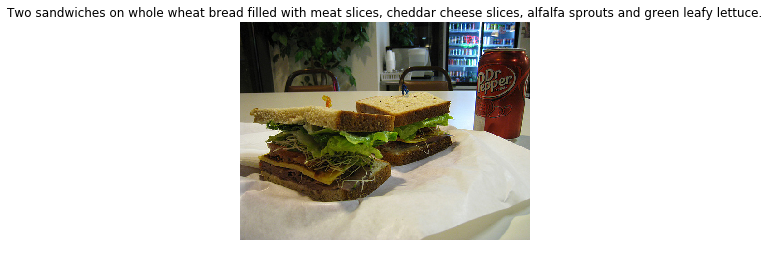

<start> a <unk> <unk> from a table <end>
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
 37s (250 50%) 4.1827]


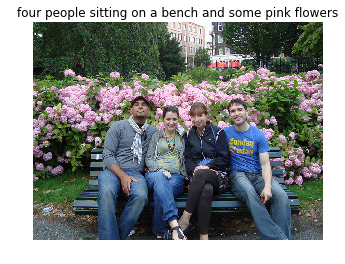

<start> a man in a <unk> <unk> on a <unk> are <end>
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
 19s (260 52%) 4.4364]


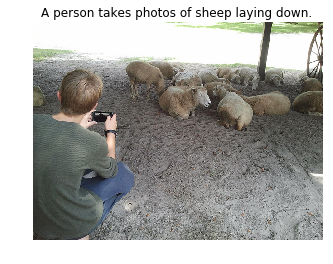

<start> a person is standing on a man and a <unk> <end>
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
fetched.
 32s (270 54%) 4.1748]


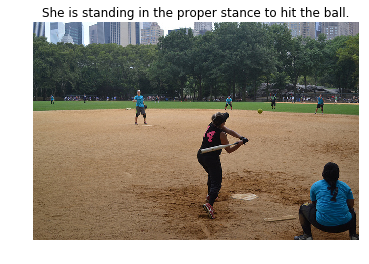

<start> a man is sitting on a man is walking in a <unk> and a <unk> <end>
fetched.
fetched.
fetched.


KeyboardInterrupt: 

In [33]:
lr = 5e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 500
start = time.time()
print_fq = 10
plot_fq = 10

for epoch in range(1, epochs+1):
    loss1 = train(batch_size)
    loss_avg += loss1
    if epoch % print_fq == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / epochs * 100, loss1))
        #print(run('\n', 150, 0.5), '\n')
        img, _ = random_image_cap(True)
        print(model.run(img))
        

    if epoch % plot_fq == 0:
        losses.append(loss_avg / plot_fq)
        loss_avg = 0
    
#print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / epochs * 100, loss1))